In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
# !git pull

In [3]:
import tensorflow as tf
import malaya_speech
import malaya_speech.train
from malaya_speech.train.model import tacotron2_nvidia as tacotron2
import numpy as np






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





In [4]:
input_ids = tf.placeholder(tf.int32, [1, None])
input_lengths = tf.placeholder(tf.int32, [1])
mel_outputs = tf.placeholder(tf.float32, [1, None, 80])
mel_lengths = tf.placeholder(tf.int32, [1])

In [5]:
_pad = 'pad'
_start = 'start'
_eos = 'eos'
_punctuation = "!'(),.:;? "
_special = '-'
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

MALAYA_SPEECH_SYMBOLS = (
    [_pad, _start, _eos] + list(_special) + list(_punctuation) + list(_letters)
)

In [6]:
model = tacotron2.Model([input_ids, input_lengths], 
                        [mel_outputs, mel_lengths], 
                        len(MALAYA_SPEECH_SYMBOLS), training = False)



Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for u

In [7]:
r = model.decoder_logits['outputs']
decoder_output, post_mel_outputs, alignment_histories, _, _, _ = r
stop_token_predictions = model.decoder_logits['stop_token_prediction']
stop_token_predictions = stop_token_predictions[:, :, 0]

In [8]:
decoder_output = tf.identity(decoder_output, name = 'decoder_output')
post_mel_outputs = tf.identity(post_mel_outputs, name = 'post_mel_outputs')
alignment_histories = tf.identity(alignment_histories, name = 'alignment_histories')

In [9]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [10]:
path = 'tacotron2-case-husein'
ckpt_path = tf.train.latest_checkpoint(path)
ckpt_path

'tacotron2-case-husein/model.ckpt-34000'

In [11]:
saver = tf.train.Saver()
saver.restore(sess, ckpt_path)

INFO:tensorflow:Restoring parameters from tacotron2-case-husein/model.ckpt-34000


In [12]:
import re
from unidecode import unidecode
import malaya

# Regular expression matching text enclosed in curly braces:
_curly_re = re.compile(r"(.*?)\{(.+?)\}(.*)")

normalizer = malaya.normalize.normalizer(date = False, time = False)
pad_to = 8

def tts_encode(string: str, add_eos: bool = True):
    r = [MALAYA_SPEECH_SYMBOLS.index(c) for c in string if c in MALAYA_SPEECH_SYMBOLS]
    if add_eos:
        r = r + [MALAYA_SPEECH_SYMBOLS.index('eos')]
    return r

def put_spacing_num(string):
    string = re.sub('[A-Za-z]+', lambda ele: ' ' + ele[0] + ' ', string)
    return re.sub(r'[ ]+', ' ', string).strip()

def convert_to_ascii(string):
    return unidecode(string)

def collapse_whitespace(string):
    return re.sub(_whitespace_re, ' ', string)

def cleaning(string, normalize = True, add_eos = True):
    sequence = []
    string = convert_to_ascii(string)
    string = string.replace('&', ' dan ')
    string = put_spacing_num(string)
    if normalize:
        string = normalizer.normalize(string, 
                                      check_english = False, 
                                      normalize_entity = False, 
                                      normalize_text = False,
                                      normalize_url = True,
                                      normalize_email = True)
        string = string['normalize']
    else:
        string = string
    string = string.lower()
    string = re.sub(r'[ ]+', ' ', string).strip()
    ids = tts_encode(string, add_eos = add_eos)
    text_input = np.array(ids)
    num_pad = pad_to - ((len(text_input) + 2) % pad_to)
    text_input = np.pad(
        text_input, ((1, 1)), 'constant', constant_values = ((1, 2))
    )
    text_input = np.pad(
        text_input, ((0, num_pad)), 'constant', constant_values = 0
    )
    
    return string, text_input

In [13]:
import matplotlib.pyplot as plt

In [14]:
t, ids = cleaning('Pertama saranan agar kebatinan, dan aliran kerohanian peribumi yang lain.', add_eos = False)
t, np.array(ids)

('pertama saranan agar kebatinan , dan aliran kerohanian peribumi yang lain .',
 array([ 1, 55, 44, 57, 59, 40, 52, 40, 13, 58, 40, 57, 40, 53, 40, 53, 13,
        40, 46, 40, 57, 13, 50, 44, 41, 40, 59, 48, 53, 40, 53, 13,  8, 13,
        43, 40, 53, 13, 40, 51, 48, 57, 40, 53, 13, 50, 44, 57, 54, 47, 40,
        53, 48, 40, 53, 13, 55, 44, 57, 48, 41, 60, 52, 48, 13, 64, 40, 53,
        46, 13, 51, 40, 48, 53, 13,  9,  2,  0,  0,  0]))

In [ ]:
t, ids = cleaning('shafiqah idayu busuk masam ketiak bau hangit', add_eos = False)
t, np.array(ids)

In [ ]:
t, ids = cleaning('pengaturcaraan adalah suatu kaedah memberi arahan atau perintah kepada komputer untuk menjalankan sesuatu tugas (atau mana-mana mesin elektronik)', add_eos = False)
t, ids

In [ ]:
t, ids = cleaning('Syed Saddiq berkata mereka seharusnya, mengingati bahawa semasa menjadi Perdana Menteri Pakatan Harapan', add_eos = False)
t, ids

In [ ]:
t, ids = cleaning('Secara amnya, ini adalah koalisi yang melibatkan Pakatan Harapan - Keadilan, DAP dan Amanah - kembali bersama Tun Dr Mahathir Mohamad dan kemnya (partinya Pejuang yang masih belum berdaftar)')
t, ids

In [15]:
o = sess.run(model.decoder_logits,
            feed_dict = {input_ids: [ids], input_lengths: [len(ids)]})

In [16]:
o['outputs'][0].shape, o['outputs'][1].shape, o['outputs'][2].shape

((1, 488, 80), (1, 488, 80), (1, 80, 488))

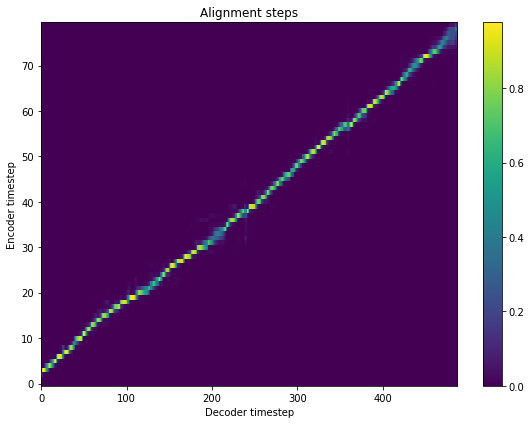

In [17]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title(f'Alignment steps')
im = ax.imshow(
    o['outputs'][2][0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

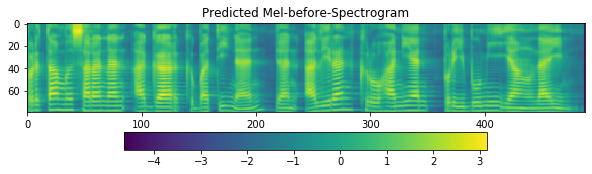

In [18]:
mel_outputs_ = np.reshape(o['outputs'][0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

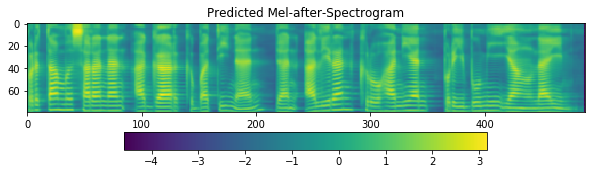

In [19]:
mel_outputs_ = np.reshape(o['outputs'][1], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [20]:
import pickle

with open('a.pkl', 'wb') as fopen:
    pickle.dump([np.reshape(o['outputs'][0], [-1, 80]), np.reshape(o['outputs'][1], [-1, 80])], fopen)

In [21]:
saver = tf.train.Saver()
saver.save(sess, 'tacotron2-husein-output/model.ckpt')

'tacotron2-husein-output/model.ckpt'

In [22]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'gather' in n.op.lower()
        or 'Placeholder' in n.name
        or 'post_mel_outputs' in n.name
        or 'decoder_output' in n.name
        or 'alignment_histories' in n.name)
        and 'adam' not in n.name
        and 'global_step' not in n.name
        and 'Assign' not in n.name
        and 'ReadVariableOp' not in n.name
        and 'Gather' not in n.name
    ]
)
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Placeholder_2',
 'Placeholder_3',
 'tacotron2_encoder/EncoderEmbeddingMatrix',
 'tacotron2_encoder/embedding_lookup',
 'tacotron2_encoder/conv1/kernel',
 'tacotron2_encoder/conv1/bn/gamma',
 'tacotron2_encoder/conv1/bn/beta',
 'tacotron2_encoder/conv1/bn/moving_mean',
 'tacotron2_encoder/conv1/bn/moving_variance',
 'tacotron2_encoder/conv2/kernel',
 'tacotron2_encoder/conv2/bn/gamma',
 'tacotron2_encoder/conv2/bn/beta',
 'tacotron2_encoder/conv2/bn/moving_mean',
 'tacotron2_encoder/conv2/bn/moving_variance',
 'tacotron2_encoder/conv3/kernel',
 'tacotron2_encoder/conv3/bn/gamma',
 'tacotron2_encoder/conv3/bn/beta',
 'tacotron2_encoder/conv3/bn/moving_mean',
 'tacotron2_encoder/conv3/bn/moving_variance',
 'tacotron2_encoder/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel',
 'tacotron2_encoder/bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/bias',
 'tacotron2_encoder/bidirectional_rnn/bw/multi_rnn_cell/cell_0/lstm_cell/kernel',
 'tacotr

In [23]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [24]:
freeze_graph('tacotron2-husein-output', strings)

INFO:tensorflow:Restoring parameters from tacotron2-husein-output/model.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 64 variables.
INFO:tensorflow:Converted 64 variables to const ops.
956 ops in the final graph.


In [25]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
                
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
        
    return graph

In [26]:
g = load_graph('tacotron2-husein-output/frozen_model.pb')

In [27]:
test_sess = tf.InteractiveSession(graph = g)

In [28]:
X = g.get_tensor_by_name(f'import/Placeholder:0')
X_len = g.get_tensor_by_name(f'import/Placeholder_1:0')

In [29]:
output_nodes = ['decoder_output',
'post_mel_outputs',
'alignment_histories']
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}
outputs

{'decoder_output': <tf.Tensor 'import/decoder_output:0' shape=(?, ?, 80) dtype=float32>,
 'post_mel_outputs': <tf.Tensor 'import/post_mel_outputs:0' shape=(?, ?, 80) dtype=float32>,
 'alignment_histories': <tf.Tensor 'import/alignment_histories:0' shape=(?, ?, ?) dtype=float32>}

In [30]:
o = test_sess.run(outputs, feed_dict = {X: [ids], X_len: [len(ids)]})

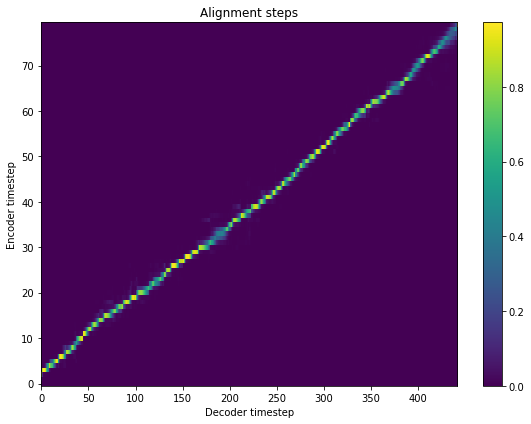

In [31]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o['alignment_histories'][0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

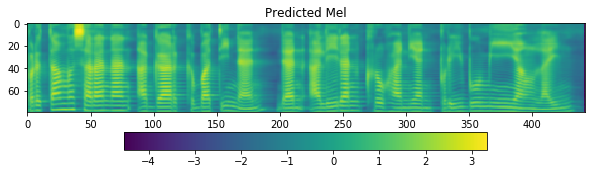

In [32]:
mel_outputs_ = np.reshape(o['post_mel_outputs'][0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('Predicted Mel')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [33]:
from tensorflow.tools.graph_transforms import TransformGraph

In [34]:
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-1024, fallback_max=1024)',
             'strip_unused_nodes',
             'sort_by_execution_order']

In [35]:
pb = 'tacotron2-husein-output/frozen_model.pb'

In [36]:
input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

transformed_graph_def = TransformGraph(input_graph_def, 
                                           ['Placeholder', 'Placeholder_1'],
                                           output_nodes, transforms)
    
with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

Instructions for updating:
Use tf.gfile.GFile.


In [37]:
g = load_graph('tacotron2-husein-output/frozen_model.pb.quantized')

In [38]:
test_sess = tf.InteractiveSession(graph = g)
X = g.get_tensor_by_name(f'import/Placeholder:0')
X_len = g.get_tensor_by_name(f'import/Placeholder_1:0')
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}

In [39]:
o = test_sess.run(outputs, feed_dict = {X: [ids], X_len: [len(ids)]})

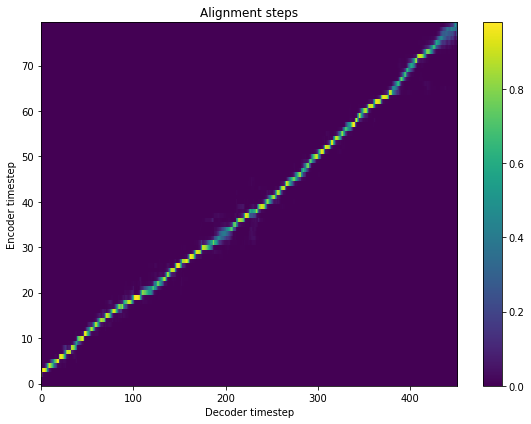

In [40]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o['alignment_histories'][0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

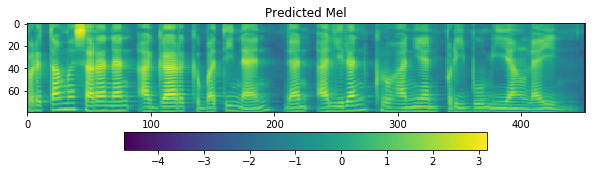

In [41]:
mel_outputs_ = np.reshape(o['post_mel_outputs'][0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('Predicted Mel')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [42]:
with open('a.pkl', 'wb') as fopen:
    pickle.dump([np.reshape(o['post_mel_outputs'][0], [-1, 80])], fopen)

In [43]:
b2_application_key_id = os.environ['b2_application_key_id']
b2_application_key = os.environ['b2_application_key']

In [44]:
from b2sdk.v1 import *
info = InMemoryAccountInfo()
b2_api = B2Api(info)
application_key_id = b2_application_key_id
application_key = b2_application_key
b2_api.authorize_account("production", application_key_id, application_key)
file_info = {'how': 'good-file'}
b2_bucket = b2_api.get_bucket_by_name('malaya-speech-model')

In [45]:
file = 'tacotron2-husein-output/frozen_model.pb'
outPutname = 'v2/tts/tacotron2-husein.pb'
b2_bucket.upload_local_file(
    local_file=file,
    file_name=outPutname,
    file_infos=file_info,
)

In [46]:
file = 'tacotron2-husein-output/frozen_model.pb.quantized'
outPutname = 'v2/tts/tacotron2-husein.pb.quantized'
b2_bucket.upload_local_file(
    local_file=file,
    file_name=outPutname,
    file_infos=file_info,
)

In [47]:
file = '/home/husein/speech-bahasa/husein-stats-v3/stats.npy'
outPutname = 'v2/vocoder-stats/husein.npy'
b2_bucket.upload_local_file(
    local_file=file,
    file_name=outPutname,
    file_infos=file_info,
)